In [4]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from abc import abstractmethod
from typing import Callable, Iterable, Tuple
from tqdm import tqdm
import pdb

In [5]:

@dataclass
class InterestRateSimulation:
    T: int = 1000
    dt: float = 0.1
    B0: float = 1.6
    D0: float = 2
    U0: float = 0.8
    r0: float = 0.02
    rB_bar: float = 0.05  # USDC borrow rate
    rD_bar: float = 0.04  # USDC deposit rate
    beta_B: float = 10
    beta_D: float = 0.2
    sigma_B: float = 1
    sigma_D: float = 0.7
    k_p: float = 2 # less than 10
    k_d: float = 2 # between 2 and 5
    u_target: float = 0.8
    seed: int = 0
    update_interval: int = 100
    
    def __post_init__(self):
        self.nsteps = int(self.T / self.dt)
        self.B = np.zeros(self.nsteps)
        self.D = np.zeros(self.nsteps)
        self.u = np.zeros(self.nsteps)
        self.r = np.zeros(self.nsteps)

        self.e = np.zeros(self.nsteps)
        self.delta_e = np.zeros(self.nsteps)
        self.jump = np.zeros(self.nsteps)
        self.speed = np.zeros(self.nsteps)
        self.bprop = np.zeros(self.nsteps)
        self.dprop = np.zeros(self.nsteps)
        

        np.random.seed(self.seed)
    
    def simulate(self):
        B, D, u, r = self.B, self.D, self.u, self.r
        e, delta_e, speed, jump = self.e, self.delta_e, self.speed, self.jump
        
        
        self.D[0] = self.D0
        self.B[0] = self.B0
        self.u[0] = self.U0
        self.r[0] = self.r0

        b_noise = np.random.normal(size=self.nsteps + 1)
        d_noise = np.random.normal(size=self.nsteps + 1)
        speed_prev = 0
        r_prev = 0
        
        for t in range(1, self.nsteps):
            if t % self.update_interval == 1:
                db = self.beta_B * (self.rB_bar - r[t-1]) * self.dt + (self.sigma_B * np.sqrt(self.dt) * b_noise[t])
                dd = self.beta_D * (r[t - 1] * (self.B[t-1] / D[t-1]) - self.rD_bar) * self.dt + (self.sigma_D * np.sqrt(self.dt) * d_noise[t])
                
                self.D[t] = self.D[t-1] + dd #  max(1e-4, self.D[t-1] + dd)
                self.B[t] = max(1e-4, min(self.B[t-1] + db, self.D[t]))
                self.u[t] = max(self.B[t] / self.D[t], 0)
                # MB described error adjustment
                e[t] = self.u[t] - self.u_target
                if e[t] > 0:
                    e[t] = e[t] / (1 - self.u_target)
                else:
                    e[t] = e[t] / self.u_target

                # update the rates
                delta_e[t] = e[t] - e[t-1]
                speed[t] = self.k_p * e[t]
                jump[t] = self.k_d**delta_e[t]
                r[t] = r[t-1] * jump[t] * (1 + speed[t] * self.dt)
                
                # bookkeeping
                r_prev = r[t]
                speed_prev = speed[t]
                self.dprop[t] = dd / self.D[t-1]
                self.bprop[t] = db / self.B[t-1]
            else:
                # only the rate should change
                r[t] = r_prev * (1 + speed_prev * (t%self.update_interval) * self.dt)
                self.B[t] = self.B[t-1]
                self.D[t] = self.D[t-1]
                self.u[t] = self.u[t-1]
                self.e[t] = self.e[t-1]
                delta_e[t] = e[t] - e[t-1]

def liquidity(u: np.ndarray, u_thresh: float=0.98, penalty: float=0.2):
    n = len(u)
    u_crit = 0
    consec = 0
    for i in range(n):
        if u[i] >= u_thresh:
            consec += 1
            u_crit += (1 + penalty * consec)
        else:
            consec = 0
    return u_crit
    
def ise(U: np.ndarray, u_target: float):
    error = np.sum((U - u_target)**2)
    return error

def ise_pos(U: np.ndarray, u_target: float):
    mask = U > u_target
    error = np.sum(((U[mask] - u_target)/(1-u_target))**2)
    return error

def volatility(R, nb_t):
    return np.sqrt(nb_t/365) * np.std(np.diff(np.log(R))) 

def volatility_percentile(R, nb_t, percentile):
    log_returns = np.diff(np.log(R))
    filtered_log_returns = log_returns[(log_returns > np.percentile(log_returns, percentile)) & (log_returns < np.percentile(log_returns, 100-percentile))]
    return np.sqrt(nb_t/365) * np.std(filtered_log_returns)
    
class IRMetric:
    @abstractmethod
    def __call__(self, sim: InterestRateSimulation):
        pass

class Liquidity(IRMetric):
    def __init__(self, u_thresh: float = 0.95, penalty: float=0.2):
        self.penalty = penalty
        self.u_thresh = u_thresh
        
    def __call__(self, sim: InterestRateSimulation):
        return liquidity(sim.u, self.u_thresh, self.penalty)

class ISE(IRMetric):
    def __call__(self, sim: InterestRateSimulation):
        u, u_target = sim.u, sim.u_target
        return ise(u, u_target)

class PLiq(IRMetric):
    def __init__(self, u_thresh: float = 0.95):
        self.u_thresh = u_thresh
        
    def __call__(self, sim: InterestRateSimulation):
        return (sim.u > self.u_thresh).sum() / len(sim.u)

class PClose(IRMetric):
    def __init__(self, window=0.05):
        self.window = window
        
    def __call__(self, sim: InterestRateSimulation):
        return ((sim.u <= sim.u_target + self.window) & (sim.u >= sim.u_target - self.window)).sum() / len(sim.u)
        

  0%|                                                                                                                                                                                | 0/4 [00:00<?, ?it/s]

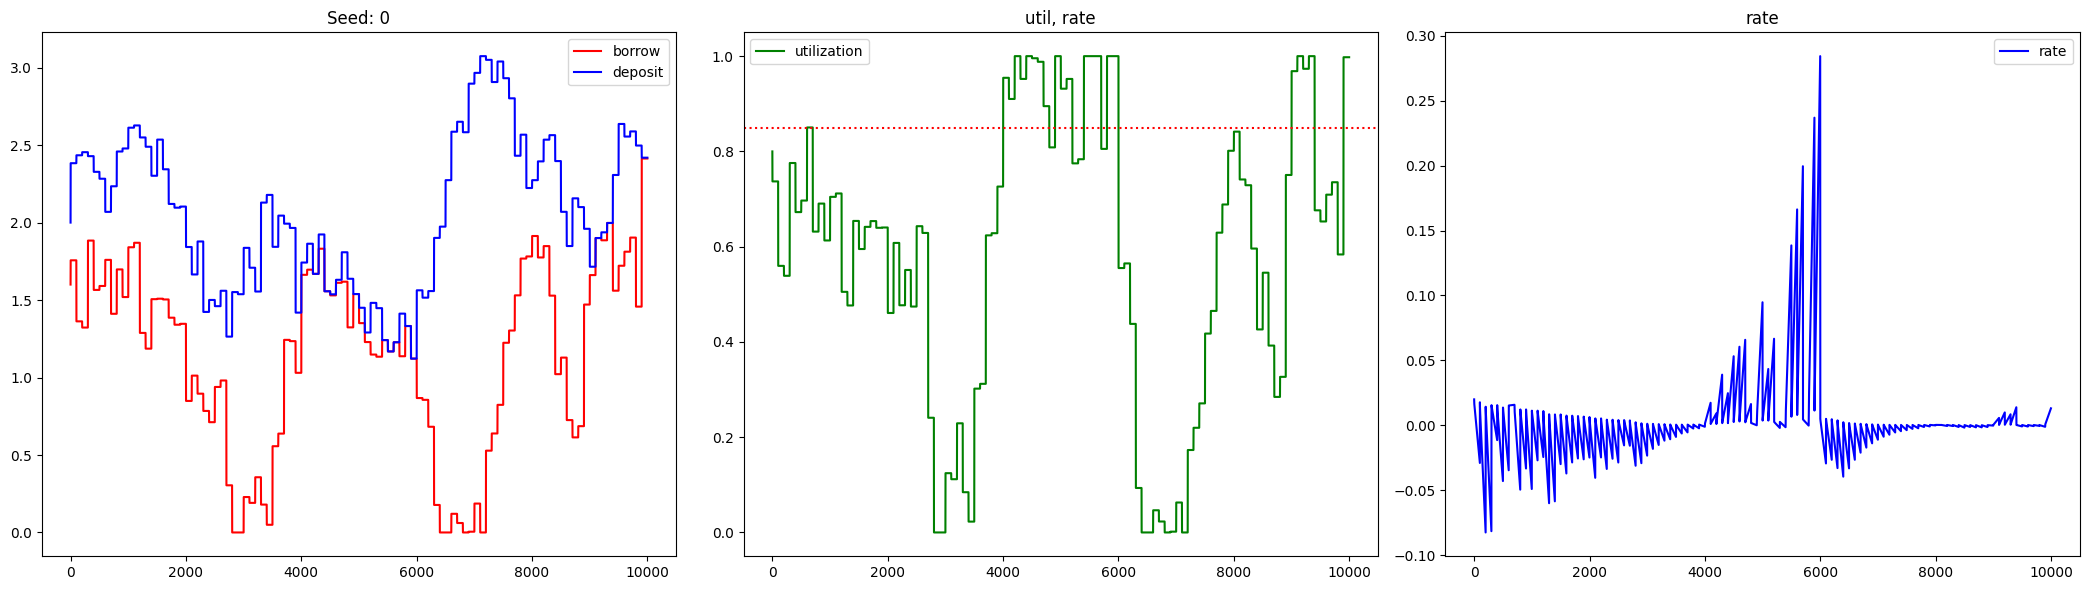

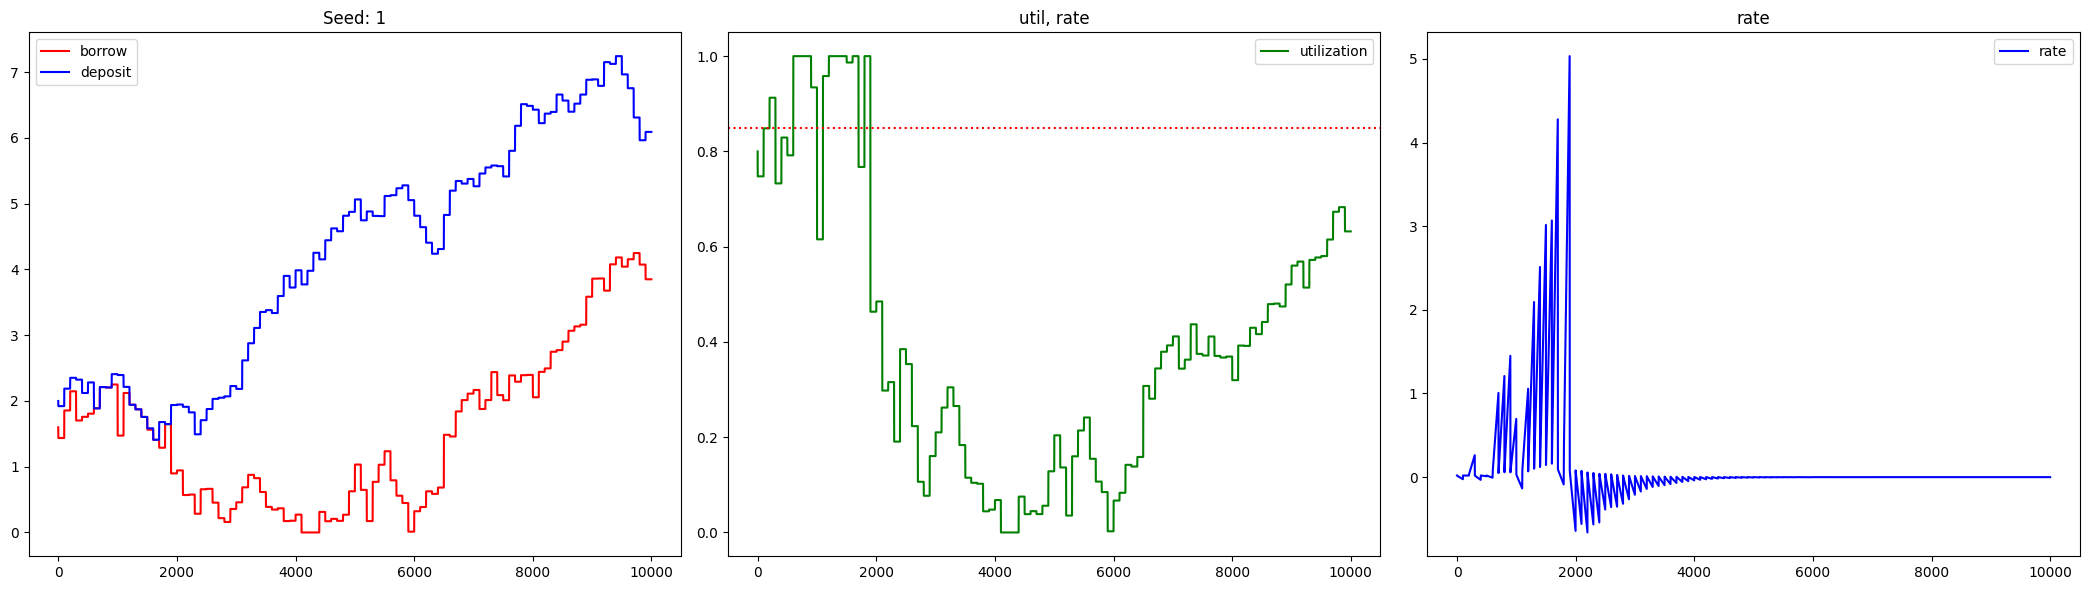

 25%|██████████████████████████████████████████                                                                                                                              | 1/4 [00:00<00:02,  1.28it/s]

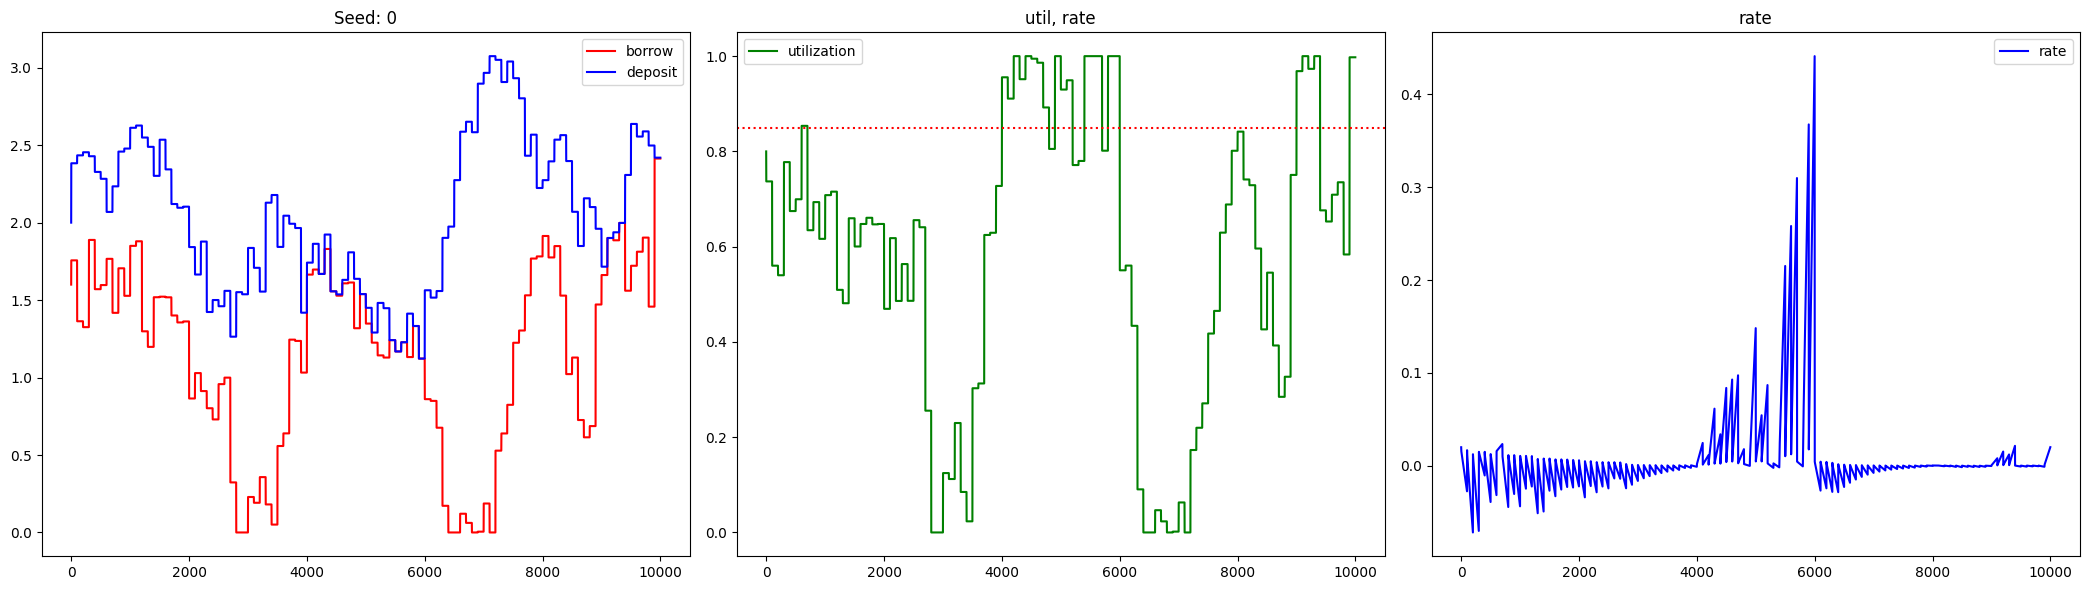

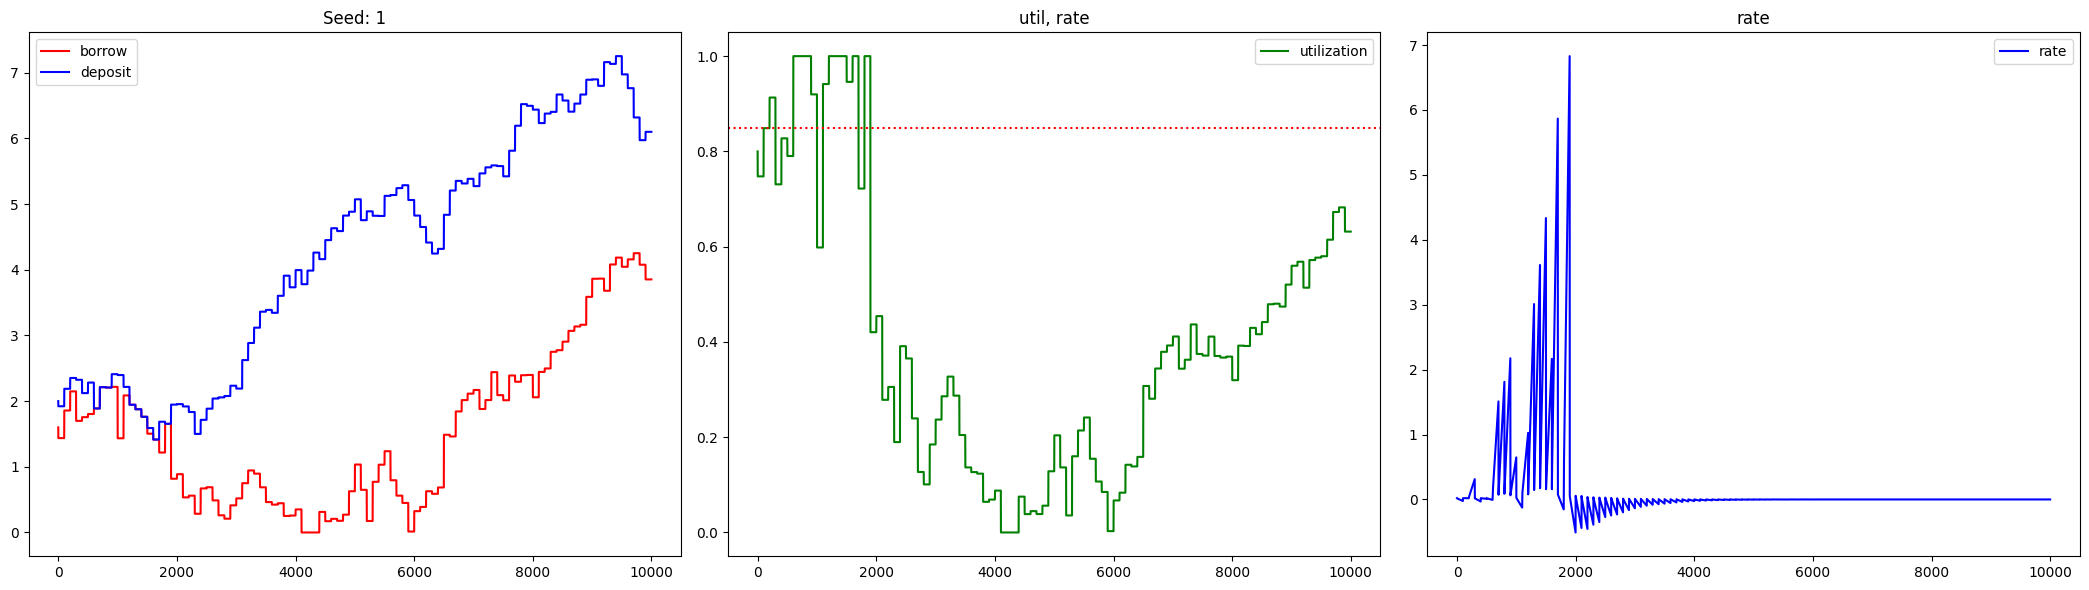

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2/4 [00:01<00:01,  1.45it/s]

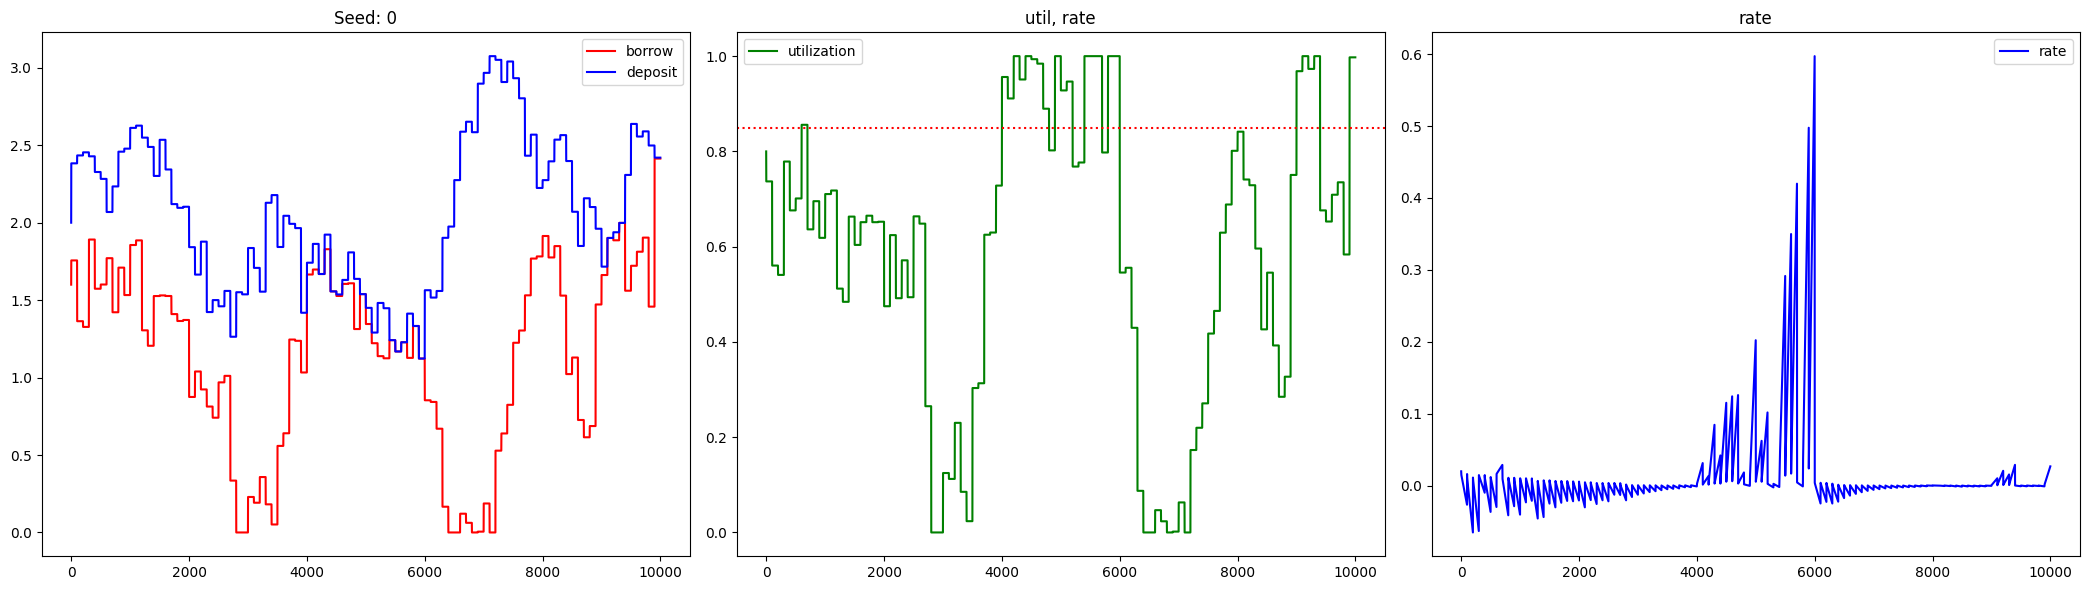

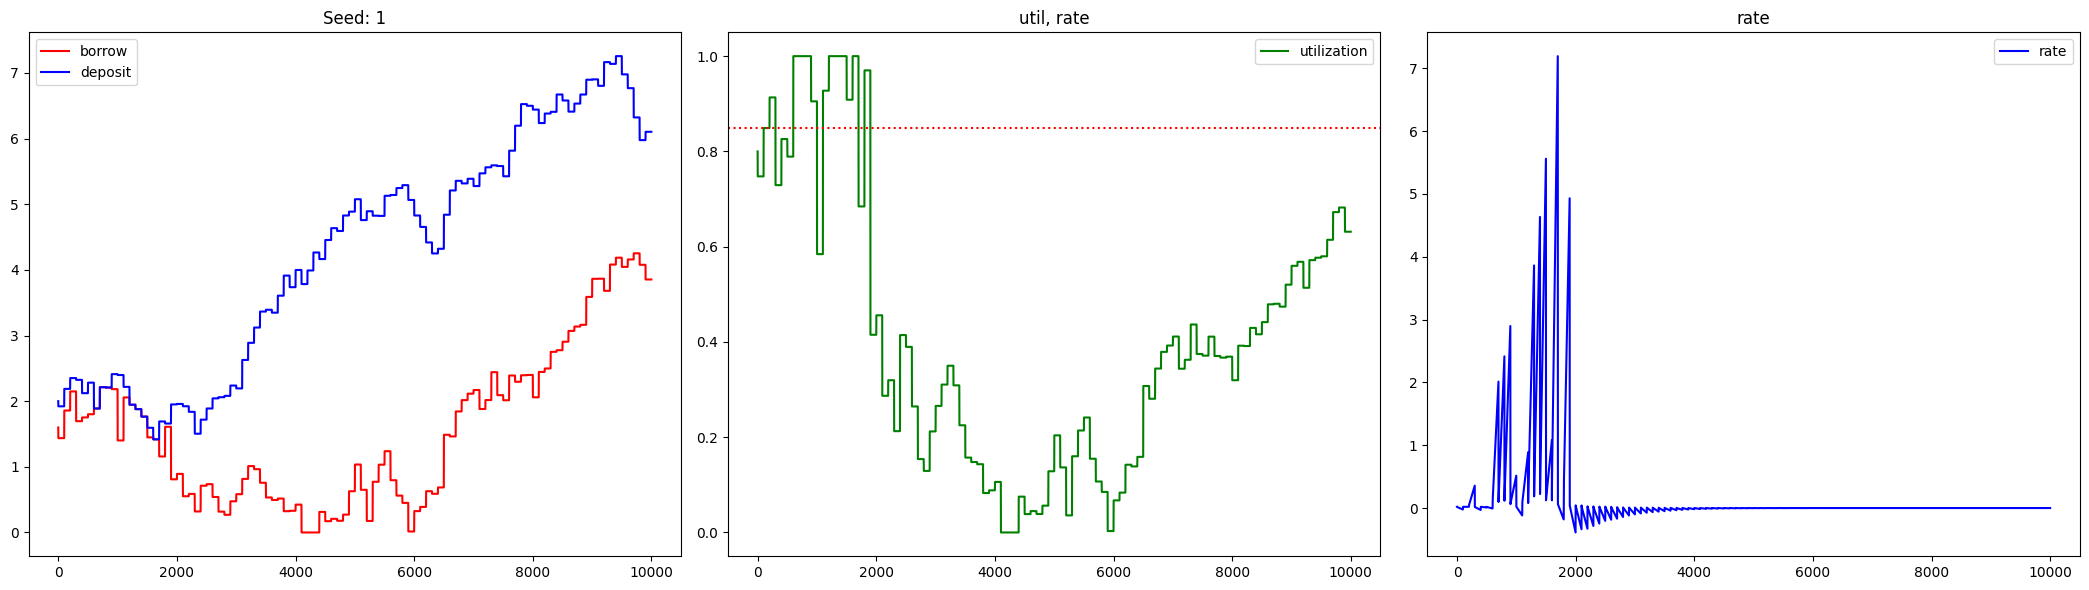

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3/4 [00:02<00:00,  1.48it/s]

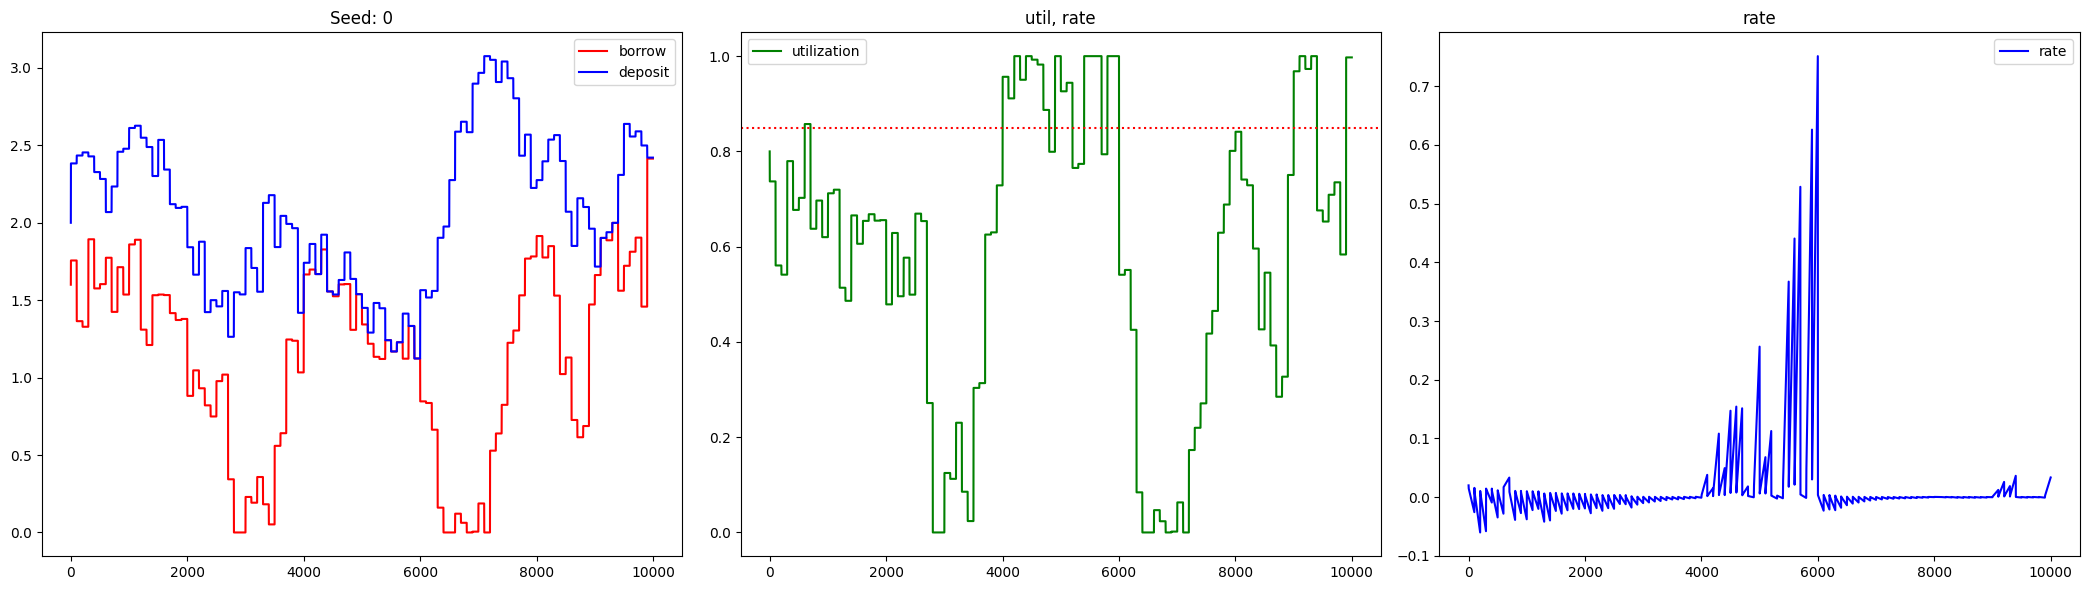

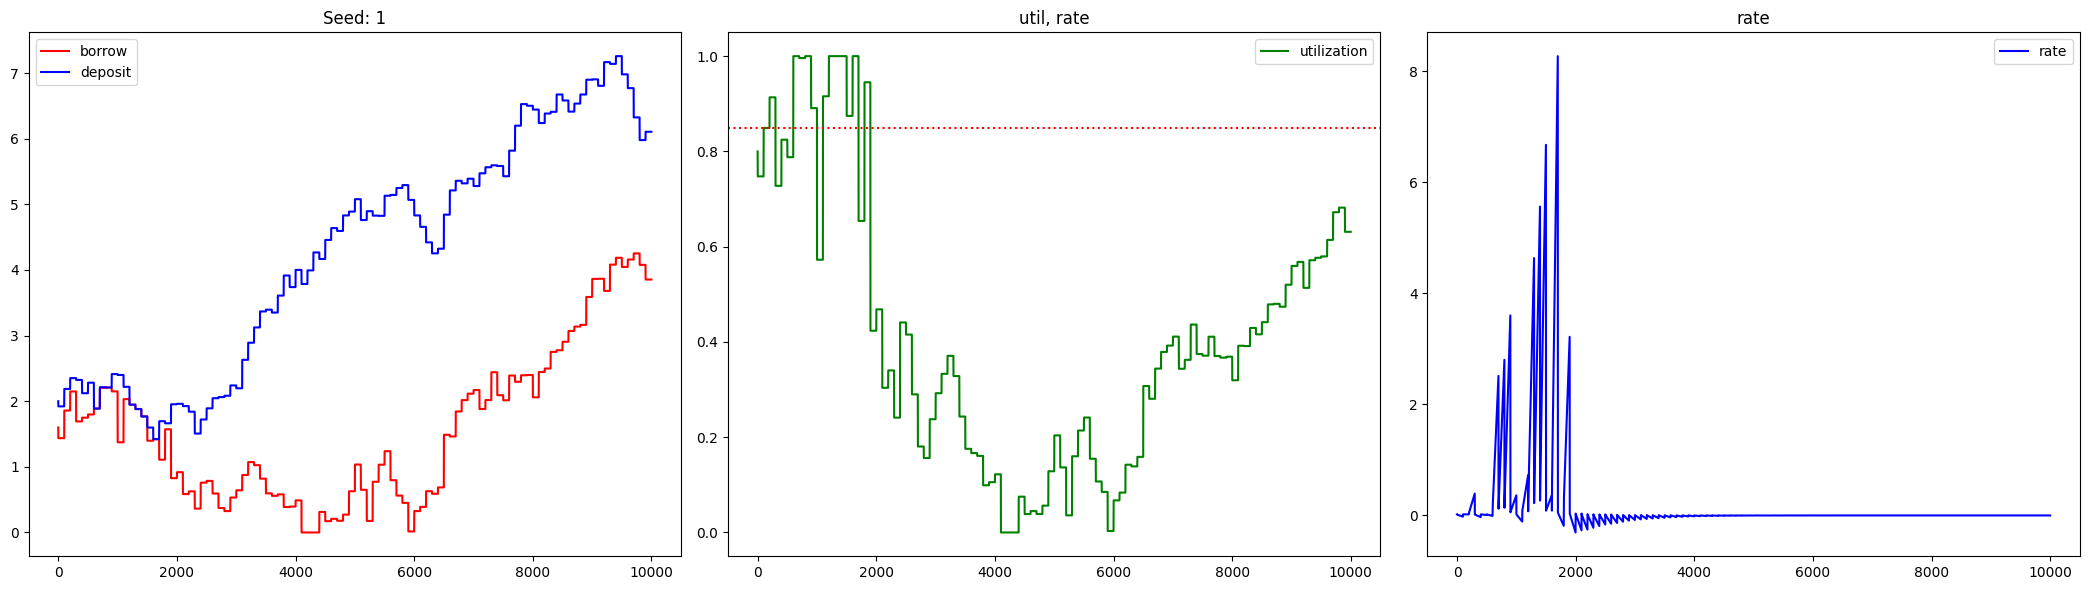

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.47it/s]


In [6]:
# metric = Liquidity(u_thresh=0.95, penalty=0.2)
metric = PClose(window=0.05) # want to minimize time above 0.95 utilization
results = {}
u_target = 0.85
for k_d in tqdm(range(2, 6)):
    results[k_d] = {'vals': []}
    for s in range(10):
        sim = InterestRateSimulation(k_d=k_d, u_target=u_target, seed=s, update_interval=100)
        sim.simulate()
        results[k_d]['vals'].append(metric(sim))
        if s > 1:
            continue
            
        plt.figure(figsize=(21, 6))
        plt.subplot(1, 3, 1)
        plt.plot(sim.B, color='r', label='borrow')
        plt.plot(sim.D, color='b', label='deposit')
        plt.legend()
        plt.title(f"Seed: {s}")
        
        plt.subplot(1, 3, 2)
        plt.plot(sim.u, color='g', label='utilization')
        plt.axhline(y=u_target, color='r', linestyle='dotted')
        plt.legend()
        plt.title("util, rate")
    
        plt.subplot(1, 3, 3)
        plt.plot(sim.r, color='b', label='rate')
        plt.legend()
        plt.title("rate")
        plt.tight_layout()
        plt.show()
        
    results[k_d]['mean'] = np.mean(results[k_d]['vals'])
    results[k_d]['std'] =  np.std(results[k_d]['vals'])

In [7]:
from scipy.optimize import minimize
from typing import Callable, Iterable, Tuple
import numpy as np

# Metric for evaluating goodness of params
def within_u_target(sim: InterestRateSimulation, radius: float = 0.05):
    tot_within = np.sum((sim.u >= sim.u_target - radius) & 
                        (sim.u <= sim.u_target + radius))
    return tot_within / len(sim.u)

def sim_eval(
    n_seeds: int,
    metric: Callable[[InterestRateSimulation], float],
    aggregate: Callable[[Iterable[float]], float] = np.mean,
) -> Callable[[Tuple[float, float]], float]:
    def f(x: Tuple[float, float, float]) -> float:
        k_p, k_d = x
        results = []
        
        for s in range(n_seeds):
            sim = InterestRateSimulation(
                    k_p=k_p,
                    k_d=k_d,
                    u_target=0.85,
                    seed=s
            )
            sim.simulate()
            results.append(metric(sim))  # Changed from eval_metric to metric
        return -aggregate(results)

    return f


f = sim_eval(100, metric=within_u_target)
k_p_init, k_d_init = 3.5, 5
init_args = (k_p_init, k_d_init)
bounds = [(2, 5), (0, 10)]

result = minimize(f, init_args, method='Nelder-Mead')

In [8]:
result.x

array([2.41240234, 7.65332031])